In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!wget https://bakrianoo.ewr1.vultrobjects.com/aravec/full_grams_cbow_300_twitter.zip
!unzip full_grams_cbow_300_twitter.zip

--2021-06-15 19:26:29--  https://bakrianoo.ewr1.vultrobjects.com/aravec/full_grams_cbow_300_twitter.zip
Resolving bakrianoo.ewr1.vultrobjects.com (bakrianoo.ewr1.vultrobjects.com)... 108.61.0.122, 2001:19f0:0:22::100
Connecting to bakrianoo.ewr1.vultrobjects.com (bakrianoo.ewr1.vultrobjects.com)|108.61.0.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3325529808 (3.1G) [application/zip]
Saving to: ‘full_grams_cbow_300_twitter.zip’

full_grams_cbow_300 100%[===================>]   3.10G  40.9MB/s    in 52s     

2021-06-15 19:27:22 (60.5 MB/s) - ‘full_grams_cbow_300_twitter.zip’ saved [3325529808/3325529808]

Archive:  full_grams_cbow_300_twitter.zip
  inflating: full_grams_cbow_300_twitter.mdl  
  inflating: full_grams_cbow_300_twitter.mdl.trainables.syn1neg.npy  
  inflating: full_grams_cbow_300_twitter.mdl.wv.vectors.npy  


# BILSTM - MAX_LEN 500 - EMBEDDINGS own - TEST_ACC 99.78

In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential,Model
from keras.layers import Input,Embedding,Bidirectional,LSTM,TimeDistributed,Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard,ReduceLROnPlateau

## PreProcess Data

In [4]:
def process_csv(csv):
    df = pd.read_csv(csv,index_col=False)[['Sentence #','Arabic','Tag','POS']]
    df=df.drop_duplicates()
    df['Arabic'] = df['Arabic'].astype(str)
    df1 = pd.DataFrame(columns = ['sentence','pos','tag'])
    for i in df['Sentence #'].unique():
        s = df[df['Sentence #'] == i]['Arabic'].tolist()
        p = df[df['Sentence #'] == i]['POS'].tolist()
        t = df[df['Sentence #'] == i]['Tag'].tolist()
        df1 = df1.append({'sentence': s, 'pos': p, 'tag':t}, ignore_index=True)
        if len(s) == len(p) and len(p) == len(t):
            continue
        else:
            print(i)
    return df1

In [5]:
csvs = os.listdir('/content/drive/MyDrive/NER_Arabic/Dataset/')
final_df = pd.DataFrame()
for csv in csvs:
    df = process_csv('/content/drive/MyDrive/NER_Arabic/Dataset/'+csv)
    final_df = pd.concat([final_df,df])
final_df = final_df.sample(frac = 1)
final_df.reset_index(drop=True, inplace=True)
final_df.head()

,sentence,pos,tag
0,"[أخبار, منافذ, في, ال, متحد, تنص على, نكون, ال...","[NNP, NNS, IN, DT, NNP, NNPS, VBP, VBG, IN, NN...","[O, O, O, O, B-geo, I-geo, O, O, O, B-per, I-p..."
1,"[ال, خاص, ملعب تنس, في, بلغراد, الاثنين, حكم, ...","[DT, JJ, NN, IN, NNP, NNP, VBD, NNS, VBG, CD, ...","[O, O, O, O, B-geo, B-tim, O, O, O, O, O, O, O..."
2,"[ال, خماسي الاضلاع, يقول, هو - هي, لديها, أ, ن...","[DT, NNP, VBZ, PRP, VBZ, DT, RB, VBN, NN, TO, ...","[O, B-org, O, O, O, O, O, O, O, O, O, O, O, O,..."
3,"[Loading..., يقول, ال, Loading..., هو, Loading...","[NNP, VBZ, DT, NN, VBZ, VBN, TO, VB, JJ, JJ, N...","[B-org, O, O, O, O, O, O, O, B-gpe, O, O, O, O]"
4,"[سلطات, لديك, مختوم, ال, قرية, إيقاف, ،, مع, ش...","[NNS, VBP, VBN, DT, NN, RP, ,, IN, NN, VBG, NN...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [6]:
embedding_dim = 300
MAX_SEQUENCE_LENGTH = 500#max([len(final_df['sentence'][i]) for i in range(len(final_df))])

In [7]:
x_tokenizer = Tokenizer(oov_token = "<OOV>")                    
x_tokenizer.fit_on_texts(final_df['sentence'].tolist())  
VOCABULARY_SIZE = len(x_tokenizer.word_index) + 1                  
x = x_tokenizer.texts_to_sequences(final_df['sentence'].tolist()) 

In [8]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(final_df['tag'].tolist())
y = y_tokenizer.texts_to_sequences(final_df['tag'].tolist())

In [9]:
x = pad_sequences(x, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
y = pad_sequences(y, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
y = to_categorical(y)

In [10]:
x_train = np.array(x[:int(len(x)*0.7)])
x_val = np.array(x[int(len(x)*0.7):int(len(x)*0.9)])
x_test = np.array(x[int(len(x)*0.9):])
assert len(x_train)+len(x_val)+len(x_test) == len(x)

In [11]:
y_train = np.array(y[:int(len(y)*0.7)])
y_val = np.array(y[int(len(y)*0.7):int(len(y)*0.9)])
y_test = np.array(y[int(len(y)*0.9):])
assert len(y_train)+len(y_val)+len(y_test) == len(y)

In [12]:
print("Training data shape (x y) ", x_train.shape,y_train.shape)
print("Validation data shape (x y) ", x_val.shape,y_val.shape)
print("Test data shape (x y) ", x_test.shape,y_test.shape)

Training data shape (x y)  (33571, 500) (33571, 500, 18)
Validation data shape (x y)  (9592, 500) (9592, 500, 18)
Test data shape (x y)  (4796, 500) (4796, 500, 18)


## Embedding Matrix

In [13]:
#import requests, zipfile
#from io import BytesIO
#response = requests.get("https://bakrianoo.ewr1.vultrobjects.com/aravec/full_grams_cbow_300_twitter.zip")
#zipDocument = zipfile.ZipFile(BytesIO(response.content))
#zipDocument.extractall()

In [14]:
import gensim
embedding_model = gensim.models.Word2Vec.load('full_grams_cbow_300_twitter.mdl')
embeddings = {}
for word,vector in zip(embedding_model.wv.vocab,embedding_model.wv.vectors):
    coefs = np.array(vector, dtype='float32')
    embeddings[word] = coefs
embeddings_weights = np.zeros((VOCABULARY_SIZE, embedding_dim))
for word, i in x_tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embeddings_weights[i] = embedding_vector

## Create Model

In [16]:
tagger = Sequential()
tagger.add(Input((MAX_SEQUENCE_LENGTH)))
tagger.add(Embedding(input_dim = VOCABULARY_SIZE,
                             output_dim    = embedding_dim, input_length  = MAX_SEQUENCE_LENGTH,#weights = [embeddings_matrix],
                             trainable     = True))
tagger.add(Bidirectional(LSTM(256, return_sequences=True)))
tagger.add(Bidirectional(LSTM(256, return_sequences=True)))
tagger.add(Bidirectional(LSTM(256, return_sequences=True)))
tagger.add(Bidirectional(LSTM(256, return_sequences=True)))
tagger.add(TimeDistributed(Dense(y.shape[2], activation='softmax')))
tagger.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
tagger.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          8382900   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 500, 512)          1140736   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 500, 512)          1574912   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 500, 512)          1574912   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 500, 512)          1574912   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 500, 18)           9234      
Total params: 14,257,606
Trainable params: 14,257,606
Non-trainable params: 0
__________________________________________

## Train Model

In [17]:
checkpoint = ModelCheckpoint('model_checkpoint.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, mode='min' , min_lr=0.0001)

In [18]:
result = tagger.fit(x_train, y_train, validation_data= (x_val, y_val), epochs = 20, batch_size= 128, shuffle = True,callbacks=[checkpoint,reducelr])

Epoch 1/20
263/263 [==============================] - 286s 1s/step - loss: 0.1542 - accuracy: 0.9655 - val_loss: 0.0305 - val_accuracy: 0.9934

Epoch 00001: val_accuracy improved from -inf to 0.99343, saving model to model_checkpoint.h5
Epoch 2/20
263/263 [==============================] - 273s 1s/step - loss: 0.0283 - accuracy: 0.9935 - val_loss: 0.0173 - val_accuracy: 0.9951

Epoch 00002: val_accuracy improved from 0.99343 to 0.99511, saving model to model_checkpoint.h5
Epoch 3/20
263/263 [==============================] - 274s 1s/step - loss: 0.0140 - accuracy: 0.9957 - val_loss: 0.0116 - val_accuracy: 0.9968

Epoch 00003: val_accuracy improved from 0.99511 to 0.99676, saving model to model_checkpoint.h5
Epoch 4/20
263/263 [==============================] - 274s 1s/step - loss: 0.0091 - accuracy: 0.9974 - val_loss: 0.0089 - val_accuracy: 0.9976

Epoch 00004: val_accuracy improved from 0.99676 to 0.99761, saving model to model_checkpoint.h5
Epoch 5/20
263/263 [=======================

## Evaluate Model

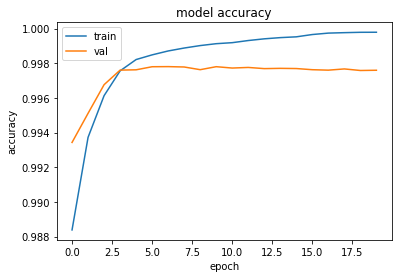

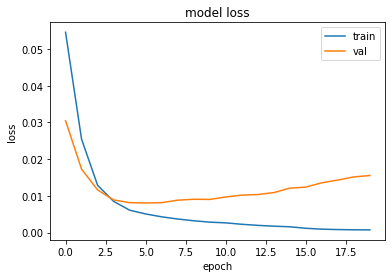

In [19]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper left')
plt.show()

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper right')
plt.show()

In [20]:
tagger.load_weights('model_checkpoint.h5')

In [21]:
loss, accuracy = tagger.evaluate(x_test, y_test)
print('Loss:',loss)
print('Accuracy:',accuracy)

150/150 [==============================] - 19s 126ms/step - loss: 0.0080 - accuracy: 0.9978
Loss: 0.007974253967404366
Accuracy: 0.9978494644165039


## Predict 

In [22]:
def pos_tagger(sent):
    words = sent.split()
    words = [x_tokenizer.texts_to_sequences(words)]
    words = pad_sequences(words, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
    words = np.squeeze(words,axis=-1)
    tags = np.squeeze(tagger.predict(words).argmax(-1))
    tags = [y_tokenizer.index_word[tag] for tag in tags if tag != 0]
    return tags

In [23]:
sentence = "جون يحب البيت الأزرق في نهاية الشارع"
output = pos_tagger(sentence)
pred_tags = [(sentence.split()[i],output[i]) for i in range(len(sentence.split()))]
for w,t in pred_tags:
    print(w,t)

جون b-per
يحب o
البيت o
الأزرق o
في o
نهاية b-tim
الشارع o
